# Dogs vs Cats Redux
Kaggle competition and first homework assignment from fastai MOOC. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

In [3]:
bs = 32

In [4]:
path = Path('../data/dogs-vs-cats-redux-kernels-edition/')
path_train = path/'train'
path_test = path/'test'

In [5]:
data = (
    ImageDataBunch.
    from_folder(path, train="train", test="test", valid_pct=0.2, 
                classes=['cat', 'dog'], ds_tfms=get_transforms(), 
                size=224, bs=bs).
    normalize(imagenet_stats)
)

/home/kai/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
test
  if getattr(ds, 'warn', False): warn(ds.warn)
/home/kai/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
test
  if getattr(ds, 'warn', False): warn(ds.warn)


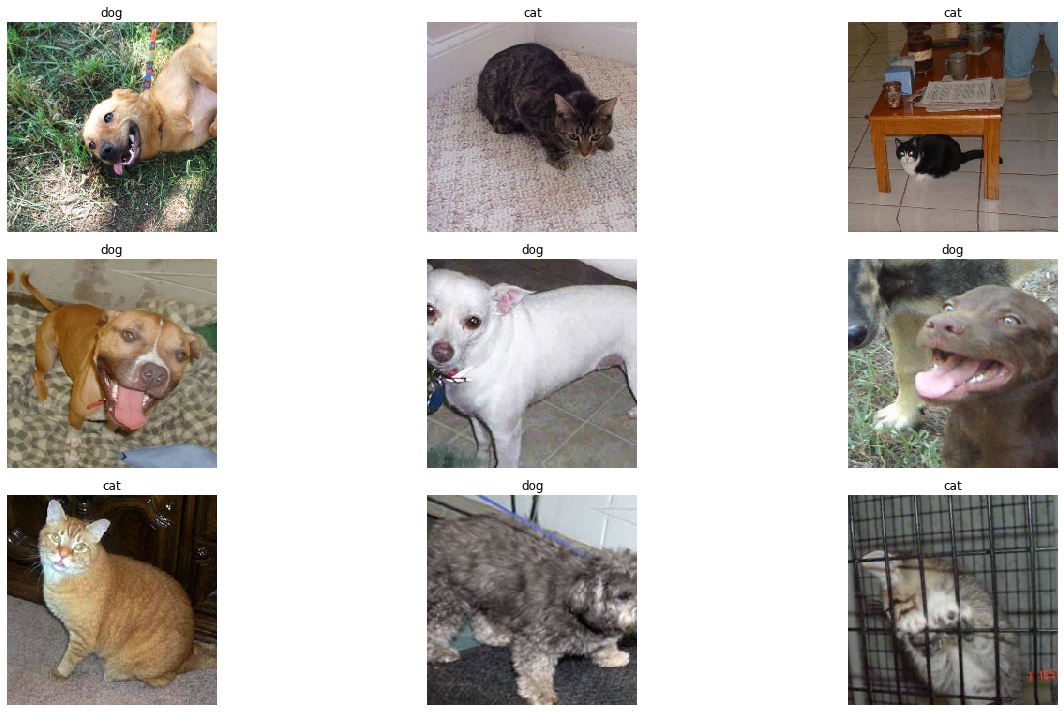

In [6]:
data.show_batch(rows=3, figsize=(20, 10))

In [7]:
print(data.classes)
len(data.classes), data.c

['cat', 'dog']


(2, 2)

In [8]:
data

ImageDataBunch;

Train: LabelList (20058 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,dog,dog,dog
Path: ../data/dogs-vs-cats-redux-kernels-edition;

Valid: LabelList (4942 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cat,cat,cat,dog,dog
Path: ../data/dogs-vs-cats-redux-kernels-edition;

Test: LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../data/dogs-vs-cats-redux-kernels-edition

## Model Fitting

### Questions
- When fitting a model initially, do we choose the learning rate from `lr_find` first or just fit without that?

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


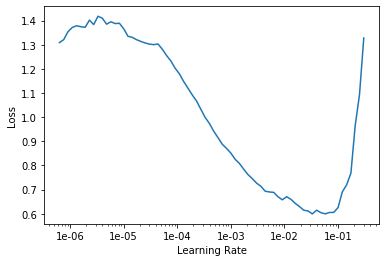

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.095828,0.055388,0.982396,0.017604,01:41
1,0.071434,0.048113,0.983812,0.016188,01:41
2,0.042920,0.031468,0.990692,0.009308,01:42
3,0.029899,0.026462,0.992513,0.007487,01:42
4,0.033141,0.026480,0.992513,0.007487,01:42
5,0.037838,0.025300,0.992513,0.007487,01:42
6,0.017288,0.022861,0.993727,0.006273,01:42
7,0.020407,0.022270,0.993525,0.006475,01:42


In [12]:
learn.save('stage-1')

In [120]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.147659,0.064047,0.977002,0.022998,02:06
1,0.079174,0.976593,0.985726,0.014274,02:07
2,0.038599,0.024993,0.991277,0.008723,02:08


In [131]:
# if things turn out worse
# learn.load('stage-1')
learn.save('stage-2')

### Analyze Results and Fine-Tuning

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

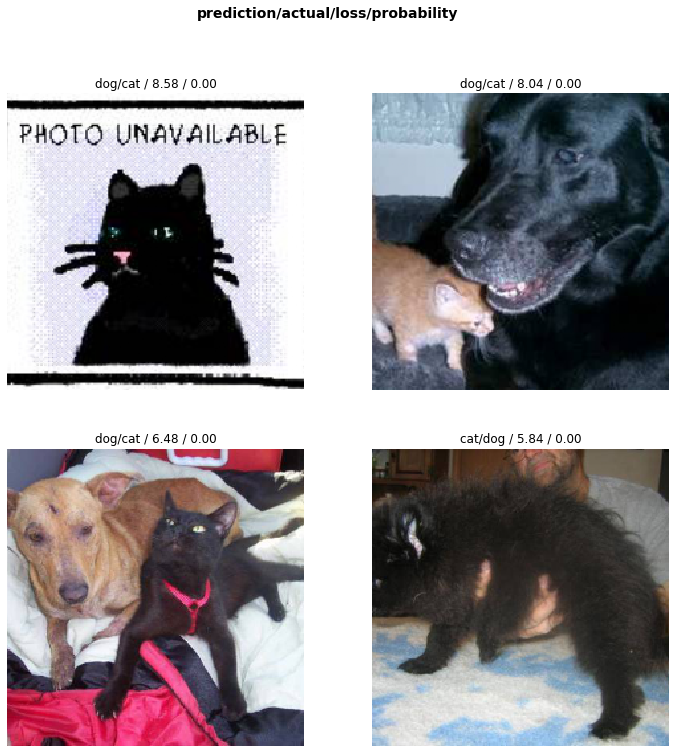

In [14]:
interp.plot_top_losses(4)

In [15]:
interp.most_confused(min_val=2)

[('cat', 'dog', 18), ('dog', 'cat', 14)]

### Creating Submission
Main issue here is the probabilities tensor is ordered in a way that isn't obvious. You need to get order of images from the dataset. Here, two lists are created with comprehensions that we can use to generate the submission csv. 

Also, this Kaggle competition, like many others uses log-loss to score submissions. `np.clip` has a pretty significant affect on this so it may be worthwhile to create a function at some point to maximize.

In [16]:
def generated_submission(preds, data, filepath='../submission.csv', 
                         low=.02, high=.98):
    """Generate submission for this competition. 
    
    Args:
        low/high: Very low or high scores get punished by log-loss if 
            predictor is wrong.
    """
    dog_proba = [np.round(np.float(p), 2) for p in (np.clip(preds[:, 1], low, high))]
    test_nums = [int(str(i).split('/')[-1][:-4]) for i in data.test_dl.dataset.items]
    
    with open(filepath, 'w') as f:
        f.write('id,label\n')
        for i, num in enumerate(test_nums):
            f.write(str(test_nums[i]) + ',' + str(dog_proba[i]) + '\n')
    print("Completed submission creation")
    print(pd.read_csv(filepath).head(5))

In [17]:
# Since test set has no labels, y ends up with a bunch of zeroes.
preds, y = learn.get_preds(DatasetType.Test)

In [154]:
print(data.test_ds)

LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../data/dogs-vs-cats-redux-kernels-edition


In [155]:
generated_submission(preds, data)

Completed submission creation
     id  label
0   657   0.98
1  6356   0.78
2  8023   0.98
3  5644   0.98
4  6634   0.02
